<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>1 | Assessment of damage associated with Russia's invasion of Ukraine in 2022</b></p>
</div>

Download all libraries needed for this project

In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import folium as F
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from math import log10, floor

# print('Matplotlib version: ', mpl.__version__)
# print(plt.style.available)
mpl.style.use(['ggplot'])

Read the CSV files into a Pandas DataFrame

In [2]:
russian_personnel = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_personnel.csv')
russian_equipment = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_equipment.csv')

## Data Wrangling
### Let's start by getting a basic understanding of the DataFrame and clean the data

In [3]:
russian_personnel

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0.0
1,2022-02-26,3,4300,about,0.0
2,2022-02-27,4,4500,about,0.0
3,2022-02-28,5,5300,about,0.0
4,2022-03-01,6,5710,about,200.0
...,...,...,...,...,...
152,2022-07-27,154,40070,about,NaN
153,2022-07-28,155,40230,about,NaN
154,2022-07-29,156,40500,about,NaN
155,2022-07-30,157,40670,about,NaN


In [4]:
#remove confusing columns and set index for sorting by date.
russian_personnel.drop(['personnel', 'personnel*'], axis=1, inplace=True)
russian_personnel.set_index('date', inplace=True)

# fill empty rows with 0 and change data type
russian_personnel.fillna(0, inplace=True)
russian_personnel = russian_personnel.astype(int)

# replace blanks at the end of data with continuous count
last = 0
newpow = []
for i in russian_personnel['POW'].values:
    if last <= i:
        last = i
    elif last > i:
        i = last
    newpow.append(i)
russian_personnel['POW'] = newpow

# view data
russian_personnel.info()
russian_personnel

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, 2022-02-25 to 2022-07-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   day     157 non-null    int64
 1   POW     157 non-null    int64
dtypes: int64(2)
memory usage: 3.7+ KB


,day,POW
date,,
2022-02-25,2,0
2022-02-26,3,0
2022-02-27,4,0
2022-02-28,5,0
2022-03-01,6,200
...,...,...
2022-07-27,154,496
2022-07-28,155,496
2022-07-29,156,496


In [5]:
russian_equipment

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,greatest losses direction,vehicles and fuel tanks,cruise missiles
0,2022-02-25,2,10,7,80,516,49,4,100.0,60.0,0,2,0,NaN,NaN,NaN,NaN,NaN
1,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN
2,2022-02-27,4,27,26,150,706,50,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN
3,2022-02-28,5,29,29,150,816,74,21,291.0,60.0,3,2,5,NaN,NaN,NaN,NaN,NaN
4,2022-03-01,6,29,29,198,846,77,24,305.0,60.0,3,2,7,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,2022-07-27,154,222,190,1738,3971,883,258,NaN,NaN,726,15,117,75.0,NaN,Kryvyi Rih,2847.0,174.0
153,2022-07-28,155,222,190,1742,3979,894,258,NaN,NaN,729,15,117,75.0,NaN,Kryvyi Rih,2854.0,174.0
154,2022-07-29,156,222,190,1749,3987,900,258,NaN,NaN,731,15,117,77.0,NaN,Kryvyi Rih,2870.0,174.0
155,2022-07-30,157,222,190,1759,3995,906,258,NaN,NaN,733,15,117,78.0,NaN,Donetsk,2889.0,174.0


In [6]:
# Check to see if there are blank cells in the data
russian_equipment.isnull()

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,greatest losses direction,vehicles and fuel tanks,cruise missiles
0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True
2,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True
3,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True
4,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False
153,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False
154,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False
155,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False


In [7]:
#fill empty spaces in Dataframe with zeroes and set index for sorting by date.
russian_equipment.fillna(0, inplace=True)
russian_equipment.set_index('date', inplace=True)
russian_equipment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, 2022-02-25 to 2022-07-31
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   day                        157 non-null    int64  
 1   aircraft                   157 non-null    int64  
 2   helicopter                 157 non-null    int64  
 3   tank                       157 non-null    int64  
 4   APC                        157 non-null    int64  
 5   field artillery            157 non-null    int64  
 6   MRL                        157 non-null    int64  
 7   military auto              157 non-null    float64
 8   fuel tank                  157 non-null    float64
 9   drone                      157 non-null    int64  
 10  naval ship                 157 non-null    int64  
 11  anti-aircraft warfare      157 non-null    int64  
 12  special equipment          157 non-null    float64
 13  mobile SRBM system         157 non-null

In [8]:
#Consolidating repetitive columns and deleting blank ones
russian_equipment['vehicles and fuel tanks'] += russian_equipment['fuel tank']
russian_equipment['special equipment'] += russian_equipment['military auto']

russian_equipment.drop(columns={'mobile SRBM system', 'fuel tank', 'military auto', 'greatest losses direction'}, inplace=True)

#Change all remaining numeric data to type int
russian_equipment = russian_equipment.astype(int)
russian_equipment.info()
russian_equipment

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, 2022-02-25 to 2022-07-31
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   day                      157 non-null    int64
 1   aircraft                 157 non-null    int64
 2   helicopter               157 non-null    int64
 3   tank                     157 non-null    int64
 4   APC                      157 non-null    int64
 5   field artillery          157 non-null    int64
 6   MRL                      157 non-null    int64
 7   drone                    157 non-null    int64
 8   naval ship               157 non-null    int64
 9   anti-aircraft warfare    157 non-null    int64
 10  special equipment        157 non-null    int64
 11  vehicles and fuel tanks  157 non-null    int64
 12  cruise missiles          157 non-null    int64
dtypes: int64(13)
memory usage: 17.2+ KB


,day,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles
date,,,,,,,,,,,,,
2022-02-25,2,10,7,80,516,49,4,0,2,0,100,60,0
2022-02-26,3,27,26,146,706,49,4,2,2,0,130,60,0
2022-02-27,4,27,26,150,706,50,4,2,2,0,130,60,0
2022-02-28,5,29,29,150,816,74,21,3,2,5,291,60,0
2022-03-01,6,29,29,198,846,77,24,3,2,7,305,60,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-27,154,222,190,1738,3971,883,258,726,15,117,75,2847,174
2022-07-28,155,222,190,1742,3979,894,258,729,15,117,75,2854,174
2022-07-29,156,222,190,1749,3987,900,258,731,15,117,77,2870,174


## Data Visualization
## Problem 1
##### Visually represent the country being invaded.

In [9]:
## Coordinates as at 03/31/2021 obtained from googlemaps
ukraine_latitude = 48.383022 
ukrain_longitude = 31.1828699
ukraine_map = F.Map(location=[ukraine_latitude, ukrain_longitude], tiles="Stamen Terrain", zoom_start=6.49)

kiev = F.map.FeatureGroup()

kiev_latitude =50.4500336
kiev_longitude =30.5241361
kiev.add_child(F.features.CircleMarker([kiev_latitude, kiev_longitude], radius=5, color="red", fill_color="blue"))
ukraine_map.add_child(kiev)

F.Marker([kiev_latitude, kiev_longitude], popup="Ukraine's Capital").add_to(ukraine_map)

ukraine_map

## Problem 2
##### Show the total Prisoners of War per day recorded in the Personel table.


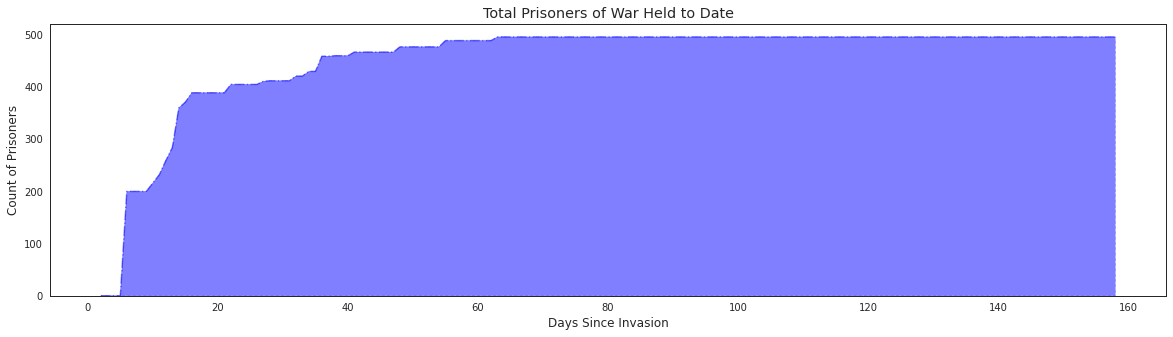

In [10]:
# Set graph style
sns.set_style('white')

# Refine data
pow_data = russian_personnel[["day", "POW"]]
pow_data.reset_index('date', inplace=True)

# Create and label plot
pow_data.plot(kind='area', x='day', y='POW', color='blue', alpha=.5, figsize=(20,5), legend=False, linestyle="-.")
plt.title('Total Prisoners of War Held to Date')
plt.xlabel('Days Since Invasion')
plt.ylabel("Count of Prisoners")
plt.show()

## Problem 3
##### What is the daily change in POW and Total POW?

In [11]:
# Helper Variables
last = 0
increase = []

# Calculate daily change in POW
for i in (pow_data['POW'].values):
    count = i - last
    increase.append(count)
    last = i
    
# Assign new values to table    
pow_data['Daily Increase in Prisoners of War'] = increase

# Style table
pow_data_ = pow_data[['day', 'POW', 'Daily Increase in Prisoners of War']].set_index('day')
pow_data_.rename(columns={'POW':'Daily Total Prisoners of War'}, inplace=True)
pow_data_.head(50)

,Daily Total Prisoners of War,Daily Increase in Prisoners of War
day,,
2,0,0
3,0,0
4,0,0
5,0,0
6,200,200
7,200,0
8,200,0
9,200,0
10,216,16


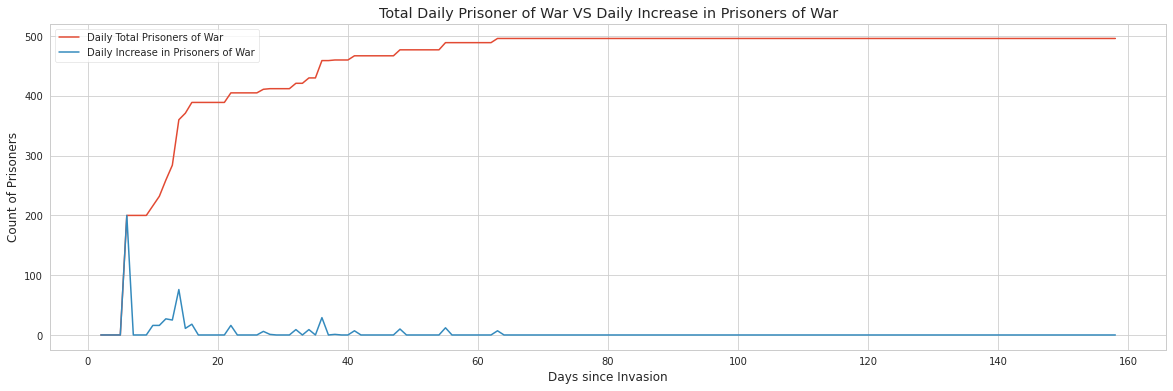

In [12]:
# Set graph style
sns.set_style('whitegrid')

# Create graph
pow_data_.plot(figsize=(20,6))
plt.xlabel('Days since Invasion')
plt.ylabel('Count of Prisoners')
plt.title("Total Daily Prisoner of War VS Daily Increase in Prisoners of War")
plt.show()

## Problem 4
##### Visualize the daily change in POW.

count    149.000000
mean       1.986577
std        7.857675
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       76.000000
Name: Daily Increase in Prisoners of War, dtype: float64


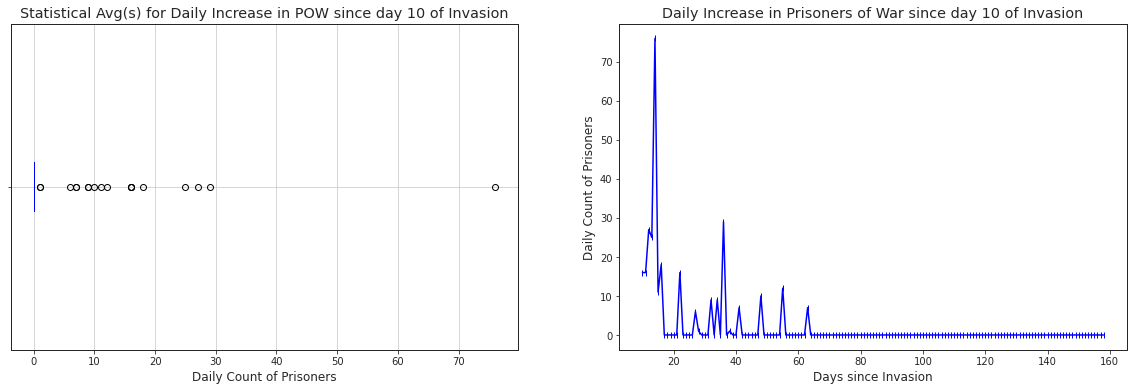

In [13]:
sns.set_style('ticks')

# Create Plot Object
fig = plt.figure()
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Assessing data after day 10 when POW is within a more narrow/normalized range. See above graph
plot_data1=pow_data_['Daily Increase in Prisoners of War'][8:]
print(plot_data1.describe())

# Subplot 1: Box plot
plot_data1.plot(kind='box', color='blue', figsize=(20, 6), vert=False, ax=ax0, notch=True, label="", 
                grid=True, patch_artist=True) 
ax0.set_title(f'Statistical Avg(s) for Daily Increase in POW since day {plot_data1.index[0]} of Invasion')
ax0.set_xlabel('Daily Count of Prisoners')

# Subplot 2: Line plot
plot_data1.plot(color='blue', figsize=(20,6), ax=ax1, marker="|")
ax1.set_xlabel('Days since Invasion')
ax1.set_ylabel('Daily Count of Prisoners')
ax1.set_title(f"Daily Increase in Prisoners of War since day {plot_data1.index[0]} of Invasion")

# Print graph
plt.show()

In [14]:
print(f'There are approximately {round(plot_data1.describe()[1])} daily prisoners of war on average.')

There are approximately 2 daily prisoners of war on average.


## Problem 5
##### What Is the total daily loss for all equipment?

In [15]:
# Structure data from dataset
daily_total_equip_loss = russian_equipment.reset_index('date')
daily_total_equip_loss.drop(columns={'date'}, inplace=True)
daily_total_equip_loss.set_index('day', inplace=True)

# Create new dataframe for graph object
daily_total_equip_loss['Daily Total Equipment Loss'] = pd.DataFrame(daily_total_equip_loss.sum(axis=1))
daily_total_equip_loss

,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,Daily Total Equipment Loss
day,,,,,,,,,,,,,
2,10,7,80,516,49,4,0,2,0,100,60,0,828
3,27,26,146,706,49,4,2,2,0,130,60,0,1152
4,27,26,150,706,50,4,2,2,0,130,60,0,1157
5,29,29,150,816,74,21,3,2,5,291,60,0,1480
6,29,29,198,846,77,24,3,2,7,305,60,0,1580
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,222,190,1738,3971,883,258,726,15,117,75,2847,174,11216
155,222,190,1742,3979,894,258,729,15,117,75,2854,174,11249
156,222,190,1749,3987,900,258,731,15,117,77,2870,174,11290


In [16]:
# Create and show graph
plot_data2 = daily_total_equip_loss[['Daily Total Equipment Loss']]
fig=px.scatter(plot_data2, x=plot_data2.index, y='Daily Total Equipment Loss', marginal_x='box', 
               color='Daily Total Equipment Loss')
fig.update_layout(plot_bgcolor='rgba(0,5,5,0)')
fig.update_layout(title={'text':'Total Equipment Lost Per Day','y':0.93,'x':0.5,'xanchor':'center','yanchor':'top'})
fig.show()

## Problem 6
##### Create a word map visual to show the equipment types with the highest percentage loss in total equipment loss.

In [17]:
sns.set_style('white')
# Get the most recent loss data
total = int(daily_total_equip_loss.iloc[-1: , -1:].values)

# gather data pertaining to the total equipment lost and generate a count of the equipment lost by type
total_loss = daily_total_equip_loss.iloc[-1: , :-1]
total_loss.reset_index(inplace=True)
total_loss = pd.DataFrame(total_loss.drop('day', axis=1).transpose()).reset_index()
total_loss.rename(columns={'index':'Equipment', 0:'Count'}, inplace=True)
total_loss.set_index('Equipment', inplace=True)
total_loss.sort_values(by='Count', inplace=True)
total_loss

,Count
Equipment,
naval ship,15
special equipment,80
anti-aircraft warfare,117
cruise missiles,174
helicopter,190
aircraft,223
MRL,259
drone,735
field artillery,916


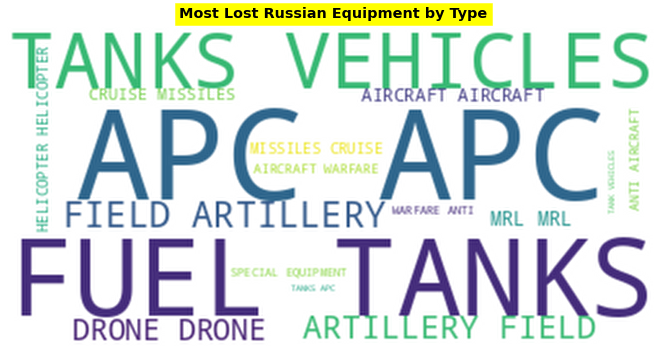

In [18]:
# duplicate equipment name based on how much they contribute to total loss
word_string=""
max_words = total_loss.mean()/2
for equipment in total_loss.index:
     times_repeat = int(total_loss.loc[equipment, 'Count']/total * max_words)
     word_string = word_string.upper() + ((equipment + " ") * times_repeat)

# create word cloud
word_cloud = WordCloud(background_color = 'white').generate(word_string)

# Display cloud
plt.figure(figsize=(20,6))
plt.imshow(word_cloud, interpolation='bessel')
plt.title('Most Lost Russian Equipment by Type', fontweight='bold', color='black', backgroundcolor='yellow')
plt.axis('off')
plt.show()

## Problem 7
##### How much equipment did Russia lose in the first 5 days of the invasion?

In [19]:
daily_total_equip_loss.head(4)

,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,Daily Total Equipment Loss
day,,,,,,,,,,,,,
2,10,7,80,516,49,4,0,2,0,100,60,0,828
3,27,26,146,706,49,4,2,2,0,130,60,0,1152
4,27,26,150,706,50,4,2,2,0,130,60,0,1157
5,29,29,150,816,74,21,3,2,5,291,60,0,1480


## Problem 8
##### What is the most recent count of equipment loss?

In [20]:
daily_total_equip_loss.tail(1)

,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,Daily Total Equipment Loss
day,,,,,,,,,,,,,
158,223,190,1763,4004,916,259,735,15,117,80,2902,174,11378


## Problem 9
##### Is there any correlation between the POW and equipment loss?

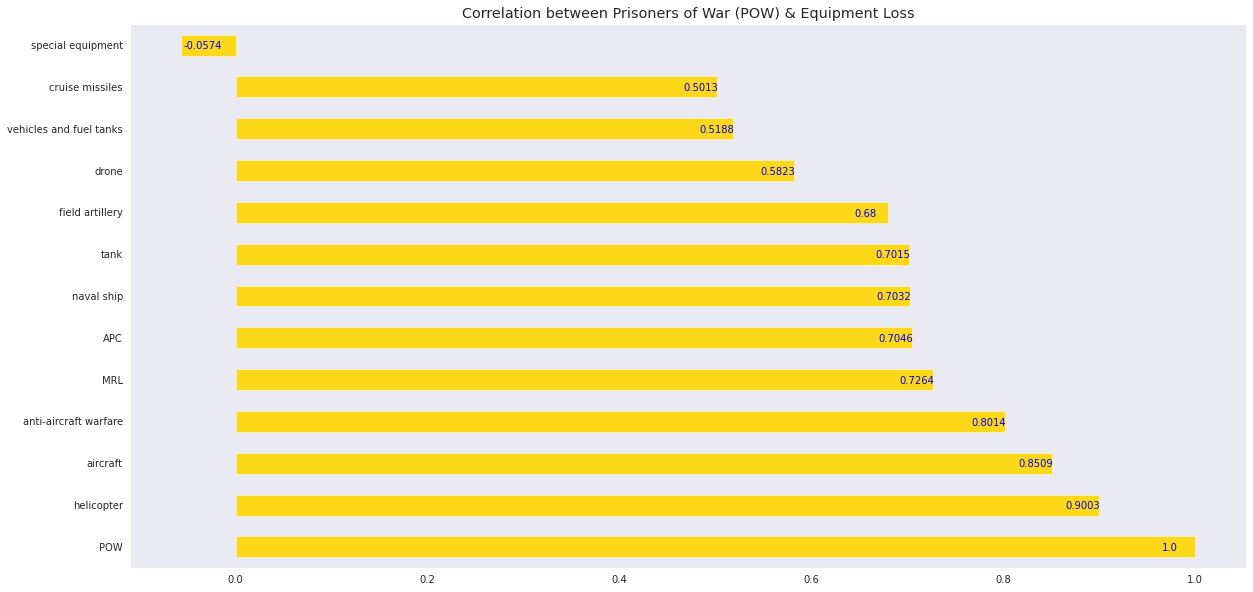

In [21]:
sns.set_style('dark')

merge = pd.merge(russian_equipment, russian_personnel).drop(['day'], axis=1)
merged = merge.corr()['POW'].sort_values(ascending=False)

merged.plot.barh(title='Correlation between Prisoners of War (POW) & Equipment Loss',
                 figsize=(20,10), alpha=.9, color='gold')
for index, value in enumerate(merged):
    value = round(value, 4)
    label = format(value)
    if value>0:
        value-=.035
    else:
        value+=.003
    plt.annotate(label, xy=(value, index-.1), color='blue')

## Problem 10
##### What inferences can you make from the relationship between POW and Equipment loss?

In [22]:
merged.describe()

count    13.000000
mean      0.662553
std       0.259144
min      -0.057411
25%       0.582305
50%       0.703167
75%       0.801376
max       1.000000
Name: POW, dtype: float64

In [23]:
m = merged.describe()
k = merged.keys()
v = merged.values

print(f"There is a very strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. As \
the POW increases, so does the overall equipment loss. The strength in correlation, ranges from {round(v[1], 3)} ({k[1]}) \
to {round(v[-1], 3)} ({k[-1]}). The median correlation is {round(m[-3], 3)} falling between {k[6]}s and {k[7]}s. The \
standard deviation is {round(m[2], 3)} which indicated that the there is not much variability in the data; all points seem \
to be close to the mean or average correlation. \n\n\
It is then valid to conclude that as the invasion continues, and POW increases so will overall equipment loss especially \
the loss of {k[1]}s by at least {round(m[1], 3)} when compared to POW.")

There is a very strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. As the POW increases, so does the overall equipment loss. The strength in correlation, ranges from 0.9 (helicopter) to -0.057 (special equipment). The median correlation is 0.703 falling between naval ships and tanks. The standard deviation is 0.259 which indicated that the there is not much variability in the data; all points seem to be close to the mean or average correlation. 

It is then valid to conclude that as the invasion continues, and POW increases so will overall equipment loss especially the loss of helicopters by at least 0.663 when compared to POW.


<!-- It should be noted that the strongest correlation exists not between the equipmet type with the highest loss({}) but with the type that had the ({}) highest loss. -->


<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>- Thank you</b></p>
</div>
